# インポート

In [10]:
from pathlib import Path
import json

## issue_numberを取得

In [11]:
from pathlib import Path
import json

def read_issue_number():
    """
    issue_numberをjsonで取得する関数
    """
    # このファイル自身の場所（scripts/）
    base_dir = Path(__file__).resolve().parent
    # /boatrace/db/scrape_race_schedule_dict.json
    json_path = base_dir.parent / "db" / "issue_number.json"
    with open(json_path, "r", encoding="utf-8") as f:
        issue_number_list = json.load(f)
    return issue_number_list

## テーブルの取得

In [12]:
import urllib.request as req

url = "https://takarakuji.rakuten.co.jp/backnumber/loto6/202601/"
html = req.urlopen(url).read()

In [13]:
import pandas as pd

pd.read_html(html, encoding="utf-8")

[         回号        第2065回      第2065回.1      第2065回.2      第2065回.3  \
 0      抽せん日    2026/01/05    2026/01/05    2026/01/05    2026/01/05   
 1       本数字             6            18            21            31   
 2    ボーナス数字           (3)           NaN           NaN           NaN   
 3        1等          該当なし          該当なし          該当なし          該当なし   
 4        2等            5口            5口            5口   15,198,300円   
 5        3等          215口          215口          215口      381,700円   
 6        4等       10,741口       10,741口       10,741口        8,000円   
 7        5等      178,338口      178,338口      178,338口        1,000円   
 8  キャリーオーバー  259,218,384円  259,218,384円  259,218,384円  259,218,384円   
 
        第2065回.4      第2065回.5  
 0    2026/01/05    2026/01/05  
 1            37            40  
 2           NaN           NaN  
 3          該当なし          該当なし  
 4   15,198,300円   15,198,300円  
 5      381,700円      381,700円  
 6        8,000円        8,000円  
 7        1,00

In [14]:
import json

with open("../db/issue_number.json", "rb") as f:
    issue_number_list = json.load(f)

In [15]:
issue_number_list

['202601',
 '202512',
 '202511',
 '202510',
 '202509',
 '202508',
 '202507',
 '202506',
 '202505',
 '202504',
 '202503',
 '202502',
 '1961-1969',
 '1941-1960',
 '1921-1940',
 '1901-1920',
 '1881-1900',
 '1861-1880',
 '1841-1860',
 '1821-1840',
 '1801-1820',
 '1781-1800',
 '1761-1780',
 '1741-1760',
 '1721-1740',
 '1701-1720',
 '1681-1700',
 '1661-1680',
 '1641-1660',
 '1621-1640',
 '1601-1620',
 '1581-1600',
 '1561-1580',
 '1541-1560',
 '1521-1540',
 '1501-1520',
 '1481-1500',
 '1461-1480',
 '1441-1460',
 '1421-1440',
 '1401-1420',
 '1381-1400',
 '1361-1380',
 '1341-1360',
 '1321-1340',
 '1301-1320',
 '1281-1300',
 '1261-1280',
 '1241-1260',
 '1221-1240',
 '1201-1220',
 '1181-1200',
 '1161-1180',
 '1141-1160',
 '1121-1140',
 '1101-1120',
 '1081-1100',
 '1061-1080',
 '1041-1060',
 '1021-1040',
 '1001-1020',
 '0981-1000',
 '0961-0980',
 '0941-0960',
 '0921-0940',
 '0901-0920',
 '0881-0900',
 '0861-0880',
 '0841-0860',
 '0821-0840',
 '0801-0820',
 '0781-0800',
 '0761-0780',
 '0741-0760',


In [16]:
from pathlib import Path

HTML_DIR = Path("..", "data", "html")
HTML_DIR

PosixPath('../data/html')

In [ ]:
import time

for issue_number in issue_number_list:
    if "-" not in issue_number:
        url = f"https://takarakuji.rakuten.co.jp/backnumber/loto6/{issue_number}/"
    else:
        url = f"https://takarakuji.rakuten.co.jp/backnumber/loto6_detail/{issue_number}/"
    html = req.urlopen(url).read()
    time.sleep(1)
    with open(HTML_DIR / f"{issue_number}.bin", "wb") as f:
        f.write(html)

In [18]:
from tqdm.notebook import tqdm

def write_html(issue_number_list, save_dir: Path):
    html_path_list = []
    for issue_number in tqdm(issue_number_list):
        filepath = save_dir / f"{issue_number}.bin"
        # binファイルがすでに存在する場合はスキップする
        if filepath.is_file():
            print(f"skipped: {issue_number}")
        else:
            if "-" not in issue_number:
                url = f"https://takarakuji.rakuten.co.jp/backnumber/loto6/{issue_number}/"
            else:
                url = f"https://takarakuji.rakuten.co.jp/backnumber/loto6_detail/{issue_number}/"
            html = req.urlopen(url).read()
            time.sleep(1)
            with open(filepath, "wb") as f:
                f.write(html)
            html_path_list.append(filepath)
    return html_path_list

In [19]:
html_path_list = write_html(issue_number_list, save_dir=HTML_DIR)

  0%|          | 0/95 [00:00<?, ?it/s]

skipped: 202601
skipped: 202512
skipped: 202511
skipped: 202510
skipped: 202509
skipped: 202508
skipped: 202507
skipped: 202506
skipped: 202505
skipped: 202504
skipped: 202503
skipped: 202502
skipped: 1961-1969
skipped: 1941-1960
skipped: 1921-1940
skipped: 1901-1920
skipped: 1881-1900
skipped: 1861-1880
skipped: 1841-1860
skipped: 1821-1840
skipped: 1801-1820
skipped: 1781-1800
skipped: 1761-1780
skipped: 1741-1760
skipped: 1721-1740
skipped: 1701-1720
skipped: 1681-1700
skipped: 1661-1680
skipped: 1641-1660
skipped: 1621-1640
skipped: 1601-1620
skipped: 1581-1600
skipped: 1561-1580
skipped: 1541-1560
skipped: 1521-1540
skipped: 1501-1520
skipped: 1481-1500
skipped: 1461-1480
skipped: 1441-1460
skipped: 1421-1440
skipped: 1401-1420
skipped: 1381-1400
skipped: 1361-1380
skipped: 1341-1360
skipped: 1321-1340
skipped: 1301-1320
skipped: 1281-1300
skipped: 1261-1280
skipped: 1241-1260
skipped: 1221-1240
skipped: 1201-1220
skipped: 1181-1200
skipped: 1161-1180
skipped: 1141-1160
skipped: 1

In [20]:
html_path_list

[]

In [21]:
html_path_list = list(HTML_DIR.glob("*"))
len(html_path_list)

95

In [22]:
df3 = {}
with open('../data/html/0521-0540.bin', "rb") as f:
    html = f.read()
    dfs = pd.read_html(html)

    # 「抽せん日 / 抽選日」を含む table だけ抽出
    indexes = []
    for i, df in enumerate(dfs):
        if df.astype(str).apply(lambda x: x.str.contains("抽せん日|抽選日", na=False)).any().any():
            indexes.append(i)

    # 条件に合うものがあればそれだけ、なければ全部
    if indexes:
        target_dfs = [dfs[i] for i in indexes]
    else:
        target_dfs = dfs

    # index[回号]を設定、テーブルのを結合
    for df in target_dfs:
        # 「1等」がデータ内に含まれているか判定
        if df.astype(str).apply(lambda x: x.str.contains("1等", na=False)).any().any():
            df2 = df.drop(index=range(3, 9), errors="ignore")
            kaigou_id = df2.columns[1]
            lottery_day = df2.iat[0, 2]
            insert = df2.columns[0]
            df2.loc[df2[insert].astype(str).str.strip() == "本数字", insert] = lottery_day
            bonus_number = df2.iat[2, 1].strip("()")
            df2['ボーナス数字'] = bonus_number
            df2 = df2.drop(index=range(0, 1), errors="ignore")
            df2 = df2.drop(index=range(2, 3), errors="ignore")
            df2.columns = ['抽せん日', 'nm1', 'nm2', 'nm3', 'nm4', 'nm5', 'nm6', 'ボーナス数字']
            df2.insert(0, "回号", kaigou_id)
            df2 = df2.reset_index(drop=True)
            df3[kaigou_id] = df2
        else:
            kaigou_id = '回号'
            df.columns = ['回号', '抽せん日', 'nm1', 'nm2', 'nm3', 'nm4', 'nm5', 'nm6', 'ボーナス数字']
            df3[kaigou_id] = df
concat_df = pd.concat(df3.values())
concat_df

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,ボーナス数字
0,第0521回,2010/11/04,1,8,15,21,23,30,33
1,第0522回,2010/11/11,3,6,16,23,25,43,37
2,第0523回,2010/11/18,7,8,26,27,41,43,16
3,第0524回,2010/11/25,7,11,14,18,35,40,43
4,第0525回,2010/12/02,1,11,17,28,33,38,20
5,第0526回,2010/12/09,8,14,18,19,26,27,23
6,第0527回,2010/12/16,5,7,12,23,39,41,9
7,第0528回,2010/12/23,2,5,12,21,28,32,41
8,第0529回,2010/12/30,6,19,21,24,31,41,7
9,第0530回,2011/01/06,1,10,19,30,33,36,35


In [23]:
df3 = {}
for html_path in html_path_list:
    with open(html_path, "rb") as f:
        html = f.read()
        dfs = pd.read_html(html)

        # 「抽せん日 / 抽選日」を含む table だけ抽出
        indexes = []
        for i, df in enumerate(dfs):
            if df.astype(str).apply(lambda x: x.str.contains("抽せん日|抽選日", na=False)).any().any():
                indexes.append(i)

        # 条件に合うものがあればそれだけ、なければ全部
        if indexes:
            target_dfs = [dfs[i] for i in indexes]
        else:
            target_dfs = dfs

        # index[回号]を設定、テーブルのを結合
        for df in target_dfs:
            # 「1等」がデータ内に含まれているか判定
            if df.astype(str).apply(lambda x: x.str.contains("1等", na=False)).any().any():
                df2 = df.drop(index=range(3, 9), errors="ignore")
                kaigou_id = df2.columns[1]
                lottery_day = df2.iat[0, 2]
                insert = df2.columns[0]
                df2.loc[df2[insert].astype(str).str.strip() == "本数字", insert] = lottery_day
                bonus_number = df2.iat[2, 1].strip("()")
                df2['ボーナス数字'] = bonus_number
                df2 = df2.drop(index=range(0, 1), errors="ignore")
                df2 = df2.drop(index=range(2, 3), errors="ignore")
                df2.columns = ['抽せん日', 'nm1', 'nm2', 'nm3', 'nm4', 'nm5', 'nm6', 'ボーナス数字']
                df2.insert(0, "回号", kaigou_id)
                df2 = df2.reset_index(drop=True)
                df3[kaigou_id] = df2
            else:
                kaigou_id = '回号'
                df.columns = ['回号', '抽せん日', 'nm1', 'nm2', 'nm3', 'nm4', 'nm5', 'nm6', 'ボーナス数字']
                df3[kaigou_id] = df
concat_df = pd.concat(df3.values())
concat_df = concat_df.reset_index(drop=True)
# 抽選日を datetime に変換
concat_df["抽せん日"] = pd.to_datetime(concat_df["抽せん日"])
# 最新順に並び替え
final_df = concat_df.sort_values("抽せん日", ascending=False).reset_index(drop=True)

In [24]:
concat_df

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,ボーナス数字
0,第0821回,2013-12-12,7,10,12,34,40,43,16
1,第0822回,2013-12-16,6,11,15,24,27,33,29
2,第0823回,2013-12-19,5,6,23,30,37,38,28
3,第0824回,2013-12-23,16,19,26,27,29,32,4
4,第0825回,2013-12-26,6,10,12,16,39,40,20
...,...,...,...,...,...,...,...,...,...
114,第2034回,2025-09-15,2,13,22,25,35,37,17
115,第2035回,2025-09-18,5,10,12,17,21,35,9
116,第2036回,2025-09-22,7,10,17,26,35,42,33
117,第2037回,2025-09-25,7,12,20,23,27,29,10


In [27]:
def create_results(html_path_list):
    frames = []
    for html_path in html_path_list:
        with open(html_path, "rb") as f:
            html = f.read()
            dfs = pd.read_html(html)

            # 「抽せん日 / 抽選日」を含む table だけ抽出
            indexes = []
            for i, df in enumerate(dfs):
                if df.astype(str).apply(lambda x: x.str.contains("抽せん日|抽選日", na=False)).any().any():
                    indexes.append(i)

            # 条件に合うものがあればそれだけ、なければ全部
            if indexes:
                target_dfs = [dfs[i] for i in indexes]
            else:
                target_dfs = dfs

            # index[回号]を設定、テーブルのを結合
            for df in target_dfs:
                # 「1等」がデータ内に含まれているか判定
                if df.astype(str).apply(lambda x: x.str.contains("1等", na=False)).any().any():
                    df2 = df.drop(index=range(3, 9), errors="ignore")
                    kaigou_id = df2.columns[1]
                    lottery_day = df2.iat[0, 2]
                    insert = df2.columns[0]
                    df2.loc[df2[insert].astype(str).str.strip() == "本数字", insert] = lottery_day
                    bonus_number = df2.iat[2, 1].strip("()")
                    df2['ボーナス数字'] = bonus_number
                    df2 = df2.drop(index=range(0, 1), errors="ignore")
                    df2 = df2.drop(index=range(2, 3), errors="ignore")
                    df2.columns = ['抽せん日', 'nm1', 'nm2', 'nm3', 'nm4', 'nm5', 'nm6', 'ボーナス数字']
                    df2.insert(0, "回号", kaigou_id)
                    df2 = df2.reset_index(drop=True)
                    frames.append(df2)
                else:
                    kaigou_id = '回号'
                    df.columns = ['回号', '抽せん日', 'nm1', 'nm2', 'nm3', 'nm4', 'nm5', 'nm6', 'ボーナス数字']
                    frames.append(df)
    concat_df = pd.concat(frames)
    concat_df = concat_df.reset_index(drop=True)
    # 抽選日を datetime に変換
    concat_df["抽せん日"] = pd.to_datetime(concat_df["抽せん日"])
    # 最新順に並び替え
    concat_df = concat_df.sort_values("抽せん日", ascending=False).reset_index(drop=True)
    return concat_df

In [419]:
results = create_results(html_path_list=html_path_list)
results

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,ボーナス数字
0,第2068回,2026-01-15,2,10,13,14,29,33,32
1,第2067回,2026-01-12,3,4,12,15,32,42,31
2,第2066回,2026-01-08,8,28,30,32,37,38,5
3,第2065回,2026-01-05,6,18,21,31,37,40,3
4,第2064回,2025-12-29,2,7,24,37,39,41,3
...,...,...,...,...,...,...,...,...,...
1743,第0325回,2007-01-11,6,7,18,29,33,39,43
1744,第0324回,2007-01-04,5,13,27,37,39,41,36
1745,第0323回,2006-12-28,9,11,21,23,33,39,26
1746,第0322回,2006-12-21,18,19,22,25,35,42,36


## 連続が出る回を検証

In [420]:
results = results.sort_values("抽せん日", ascending=True).reset_index(drop=True)

In [421]:
import numpy as np

NUM_COLS = ["nm1","nm2","nm3","nm4","nm5","nm6"]

# nm1〜nm6 を int に変換（NaN があっても落ちない）
nums = results[NUM_COLS].apply(pd.to_numeric, errors="coerce").astype("Int64")

# 念のためソートしてから判定
nums_sorted = np.sort(nums.values, axis=1)

results["seq_pairs"] = (np.diff(nums_sorted, axis=1) == 1).sum(axis=1)
results

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,ボーナス数字,seq_pairs
0,第0321回,2006-12-14,21,29,31,36,38,41,10,0
1,第0322回,2006-12-21,18,19,22,25,35,42,36,1
2,第0323回,2006-12-28,9,11,21,23,33,39,26,0
3,第0324回,2007-01-04,5,13,27,37,39,41,36,0
4,第0325回,2007-01-11,6,7,18,29,33,39,43,1
...,...,...,...,...,...,...,...,...,...,...
1743,第2064回,2025-12-29,2,7,24,37,39,41,3,0
1744,第2065回,2026-01-05,6,18,21,31,37,40,3,0
1745,第2066回,2026-01-08,8,28,30,32,37,38,5,1
1746,第2067回,2026-01-12,3,4,12,15,32,42,31,1


In [317]:
results.groupby("seq_pairs").count()

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,ボーナス数字
seq_pairs,,,,,,,,,
0,791,791,791,791,791,791,791,791,791
1,719,719,719,719,719,719,719,719,719
2,205,205,205,205,205,205,205,205,205
3,32,32,32,32,32,32,32,32,32
4,1,1,1,1,1,1,1,1,1


### 仮説①
中央寄り（15〜29）が多いと連続が出やすい？

#### 評価：支持される（弱〜中）
#### 結果：中央帯に数字が寄るほど、隣接候補が増え、連続が生まれやすい

In [305]:
results["count_15~29"] = (
    results[NUM_COLS]
    .apply(lambda r: sum(15 <= int(x) <= 29 for x in r), axis=1)
)
results.groupby(results["seq_pairs"] > 0)["count_15~29"].mean()
# results.groupby("seq_pairs")["count_15~29"].mean()
# results.groupby(results["seq_pairs"] > 0)["count_15~29"].describe()

seq_pairs
False    2.070796
True     2.158830
Name: count_15~29, dtype: float64

### 仮説②
直前回との“重なり”があると連続が出やすい？

#### 評価：ほぼ差なし（支持弱）
#### 結果：直前回との“近さ”は、連続発生の主因ではない

In [306]:
def near_prev(curr_arr, prev_arr):
    curr = {int(x) for x in curr_arr if pd.notna(x)}
    prev = {int(x) for x in prev_arr if pd.notna(x)}

    near = set()
    for n in prev:
        near.update([n-1, n, n+1])

    return len(curr & near)

results["just_before_+-1"] = [
    near_prev(nums.iloc[i].values, nums.iloc[i-1].values) if i > 0 else 0
    for i in range(len(results))
]
results.groupby(results["seq_pairs"] > 0)["just_before_+-1"].mean()
# results.groupby("seq_pairs")["just_before_+-1"].mean()

seq_pairs
False    2.180784
True     2.183908
Name: just_before_+-1, dtype: float64

### 仮説③
ホット数字（rank上位）が固まると連続が出やすい？

#### 評価：支持される（中）
#### 結果：「よく出ている数字」が複数含まれる回ほど、それらが近い値に固まり、連続が生じやすい

In [307]:
results_distribution_features_df = results_distribution_features_df.sort_values("回号", ascending=True).reset_index(drop=True)
results_distribution_features_df["seq_pairs"] = results["seq_pairs"]

In [308]:
results_distribution_features_df.groupby(results_distribution_features_df["seq_pairs"] > 0)[
    ["mean_rank","min_rank","max_rank"]
].mean()
# results_distribution_features_df

,mean_rank,min_rank,max_rank
seq_pairs,,,
False,22.189003,6.412073,37.976378
True,21.796400,6.169872,37.594017


### 仮説④
ばらけすぎると連続は減る？

#### 評価：かなり支持される（中〜強）
#### 結果：数字が「自然にまとまった分布」のとき、連続は“副産物”として現れる

In [309]:
results["最大差（max−min）"] = nums.max(axis=1) - nums.min(axis=1)
results["標準偏差"] = nums.std(axis=1)
results.groupby(results["seq_pairs"] > 0)[["最大差（max−min）","標準偏差"]].mean()
# results

,最大差（max−min）,標準偏差
seq_pairs,,
False,33.152971,12.749444
True,30.314525,11.92716


## 連続する数字“そのもの”の性質

In [422]:
results = results.sort_values("抽せん日", ascending=False).reset_index(drop=True)
NUM_COLS = ["nm1","nm2","nm3","nm4","nm5","nm6"]

In [423]:
# 連続数字そのものを取得
import numpy as np

def extract_seq(nums):
    nums = sorted(nums)
    seqs = []
    for a, b in zip(nums[:-1], nums[1:]):
        if b - a == 1:
            seqs.append((a, b))
    return seqs

results["seq_values"] = results[NUM_COLS].apply(
    lambda r: extract_seq([int(x) for x in r]),
    axis=1
)
results

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,ボーナス数字,seq_pairs,seq_values
0,第2068回,2026-01-15,2,10,13,14,29,33,32,1,"[(13, 14)]"
1,第2067回,2026-01-12,3,4,12,15,32,42,31,1,"[(3, 4)]"
2,第2066回,2026-01-08,8,28,30,32,37,38,5,1,"[(37, 38)]"
3,第2065回,2026-01-05,6,18,21,31,37,40,3,0,[]
4,第2064回,2025-12-29,2,7,24,37,39,41,3,0,[]
...,...,...,...,...,...,...,...,...,...,...,...
1743,第0325回,2007-01-11,6,7,18,29,33,39,43,1,"[(6, 7)]"
1744,第0324回,2007-01-04,5,13,27,37,39,41,36,0,[]
1745,第0323回,2006-12-28,9,11,21,23,33,39,26,0,[]
1746,第0322回,2006-12-21,18,19,22,25,35,42,36,1,"[(18, 19)]"


In [424]:
results["rank_map"] = results_distribution_features_df["rank_map"]
results

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,ボーナス数字,seq_pairs,seq_values,rank_map
0,第2068回,2026-01-15,2,10,13,14,29,33,32,1,"[(13, 14)]","{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7..."
1,第2067回,2026-01-12,3,4,12,15,32,42,31,1,"[(3, 4)]","{21: 1, 42: 2, 2: 3, 7: 4, 22: 5, 28: 6, 37: 7..."
2,第2066回,2026-01-08,8,28,30,32,37,38,5,1,"[(37, 38)]","{42: 1, 21: 2, 2: 3, 7: 4, 22: 5, 5: 6, 12: 7,..."
3,第2065回,2026-01-05,6,18,21,31,37,40,3,0,[],"{42: 1, 2: 2, 21: 3, 7: 4, 22: 5, 5: 6, 12: 7,..."
4,第2064回,2025-12-29,2,7,24,37,39,41,3,0,[],"{42: 1, 21: 2, 2: 3, 7: 4, 22: 5, 5: 6, 12: 7,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1743,第0325回,2007-01-11,6,7,18,29,33,39,43,1,"[(6, 7)]",NaN
1744,第0324回,2007-01-04,5,13,27,37,39,41,36,0,[],NaN
1745,第0323回,2006-12-28,9,11,21,23,33,39,26,0,[],NaN
1746,第0322回,2006-12-21,18,19,22,25,35,42,36,1,"[(18, 19)]",NaN


### 観点A：rank との関係

In [425]:
def seq_mean_rank(row):
    seqs = row["seq_values"]
    if not seqs:
        return None

    ranks = []
    for a, b in seqs:
        ranks.append(rank_map[a])
        ranks.append(rank_map[b])

    return sum(ranks) / len(ranks)

results["seq_mean_rank"] = results.apply(seq_mean_rank, axis=1)
results

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,ボーナス数字,seq_pairs,seq_values,rank_map,seq_mean_rank
0,第2068回,2026-01-15,2,10,13,14,29,33,32,1,"[(13, 14)]","{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7...",21.5
1,第2067回,2026-01-12,3,4,12,15,32,42,31,1,"[(3, 4)]","{21: 1, 42: 2, 2: 3, 7: 4, 22: 5, 28: 6, 37: 7...",27.0
2,第2066回,2026-01-08,8,28,30,32,37,38,5,1,"[(37, 38)]","{42: 1, 21: 2, 2: 3, 7: 4, 22: 5, 5: 6, 12: 7,...",8.5
3,第2065回,2026-01-05,6,18,21,31,37,40,3,0,[],"{42: 1, 2: 2, 21: 3, 7: 4, 22: 5, 5: 6, 12: 7,...",NaN
4,第2064回,2025-12-29,2,7,24,37,39,41,3,0,[],"{42: 1, 21: 2, 2: 3, 7: 4, 22: 5, 5: 6, 12: 7,...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1743,第0325回,2007-01-11,6,7,18,29,33,39,43,1,"[(6, 7)]",NaN,18.5
1744,第0324回,2007-01-04,5,13,27,37,39,41,36,0,[],NaN,NaN
1745,第0323回,2006-12-28,9,11,21,23,33,39,26,0,[],NaN,NaN
1746,第0322回,2006-12-21,18,19,22,25,35,42,36,1,"[(18, 19)]",NaN,23.5


### 観点B：連続数字のゾーン

In [427]:
def zone(n):
    if 1 <= n <= 14: return "top"
    if 15 <= n <= 29: return "mid"
    return "low"

def seq_zone(row):
    zones = []
    for a,b in row["seq_values"]:
        zones.append(zone(a))
        zones.append(zone(b))
    return zones

results["seq_zone"] = results.apply(seq_zone, axis=1)
results

,回号,抽せん日,nm1,nm2,nm3,nm4,nm5,nm6,ボーナス数字,seq_pairs,seq_values,rank_map,seq_mean_rank,seq_zone
0,第2068回,2026-01-15,2,10,13,14,29,33,32,1,"[(13, 14)]","{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7...",21.5,"[top, top]"
1,第2067回,2026-01-12,3,4,12,15,32,42,31,1,"[(3, 4)]","{21: 1, 42: 2, 2: 3, 7: 4, 22: 5, 28: 6, 37: 7...",27.0,"[top, top]"
2,第2066回,2026-01-08,8,28,30,32,37,38,5,1,"[(37, 38)]","{42: 1, 21: 2, 2: 3, 7: 4, 22: 5, 5: 6, 12: 7,...",8.5,"[low, low]"
3,第2065回,2026-01-05,6,18,21,31,37,40,3,0,[],"{42: 1, 2: 2, 21: 3, 7: 4, 22: 5, 5: 6, 12: 7,...",NaN,[]
4,第2064回,2025-12-29,2,7,24,37,39,41,3,0,[],"{42: 1, 21: 2, 2: 3, 7: 4, 22: 5, 5: 6, 12: 7,...",NaN,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1743,第0325回,2007-01-11,6,7,18,29,33,39,43,1,"[(6, 7)]",NaN,18.5,"[top, top]"
1744,第0324回,2007-01-04,5,13,27,37,39,41,36,0,[],NaN,NaN,[]
1745,第0323回,2006-12-28,9,11,21,23,33,39,26,0,[],NaN,NaN,[]
1746,第0322回,2006-12-21,18,19,22,25,35,42,36,1,"[(18, 19)]",NaN,23.5,"[mid, mid]"


In [310]:
results.isnull().sum()

回号                 0
抽せん日               0
nm1                0
nm2                0
nm3                0
nm4                0
nm5                0
nm6                0
ボーナス数字             0
seq_pairs          0
count_15~29        0
just_before_+-1    0
最大差（max−min）       0
標準偏差               0
dtype: int64

In [311]:
save_dir = Path("..", "data", "rawdf")

In [428]:
results.to_csv(save_dir / "results.csv", sep="\t", index=False)

In [334]:
from collections import Counter

RECENT_NUMBER = 50
NUM_COLS = ['nm1', 'nm2', 'nm3', 'nm4', 'nm5', 'nm6']

def create_results_distribution_features(results):
    df = results.sort_values("回号").reset_index(drop=True)
    # 本数字をintに変更
    df[NUM_COLS] = df[NUM_COLS].apply(pd.to_numeric, errors="coerce").astype("Int64")

    def main_number_zone(rank):
        if 0 < rank and rank <= 14:
            return "top"
        elif 14 < rank and rank <= 29:
            return "mid"
        elif 29 < rank and rank <= 43:
            return "low"

    records = []
    for i in range(len(df)):
        if i < RECENT_NUMBER:
            # 直前50回が揃っていない回はスキップ
            continue

        current = df.iloc[i]
        past = df.iloc[i-RECENT_NUMBER:i]

        # 直前50回の出現回数集計
        nums = []
        for _, row in past.iterrows():
            nums.extend([row[c] for c in NUM_COLS])

        freq = Counter(nums)

        # 出ていない数字も含める（1〜43）
        all_nums = list(range(1, 44))
        ranking = sorted(
            all_nums,
            key=lambda x: (-freq.get(x, 0), x)
        )

        rank_map = {num: r+1 for r, num in enumerate(ranking)}

        # 今回の本数字の順位
        current_nums = [current[c] for c in NUM_COLS]
        current_nums = [int(x) for x in current_nums if pd.notna(x)]  # NaN除去 + int化

        ranks = [rank_map[n] for n in current_nums]

        # 順位帯分布
        zones = [main_number_zone(r) for r in ranks]
        rank_top = zones.count("top")
        rank_mid = zones.count("mid")
        rank_low = zones.count("low")

        # 要約指標
        mean_rank = sum(ranks) / len(ranks)
        min_rank  = min(ranks)
        max_rank  = max(ranks)

        records.append({
            "回号": current["回号"],
            "1~14_rank": rank_top,
            "15~29_rank": rank_mid,
            "30~43_rank": rank_low,
            "rank_map": rank_map,
            "mean_rank": round(mean_rank, 2),
            "min_rank": min_rank,
            "max_rank": max_rank
        })

    results_distribution_features_df = pd.DataFrame(records)
    # 最新順に並び替え
    results_distribution_features_df = results_distribution_features_df.sort_values("回号", ascending=False).reset_index(drop=True)
    return results_distribution_features_df

In [336]:
results_distribution_features_df = create_results_distribution_features(results=results)
results_distribution_features_df

,回号,1~14_rank,15~29_rank,30~43_rank,rank_map,mean_rank,min_rank,max_rank
0,第2068回,2,4,0,"{42: 1, 21: 2, 2: 3, 7: 4, 12: 5, 28: 6, 37: 7...",16.00,3,27
1,第2067回,2,2,2,"{21: 1, 42: 2, 2: 3, 7: 4, 22: 5, 28: 6, 37: 7...",23.83,2,40
2,第2066回,3,0,3,"{42: 1, 21: 2, 2: 3, 7: 4, 22: 5, 5: 6, 12: 7,...",24.00,8,41
3,第2065回,2,2,2,"{42: 1, 2: 2, 21: 3, 7: 4, 22: 5, 5: 6, 12: 7,...",22.17,3,35
4,第2064回,2,3,1,"{42: 1, 21: 2, 2: 3, 7: 4, 22: 5, 5: 6, 12: 7,...",18.00,3,35
...,...,...,...,...,...,...,...,...
1693,第0375回,2,3,1,"{7: 1, 15: 2, 6: 3, 8: 4, 12: 5, 34: 6, 10: 7,...",18.83,1,34
1694,第0374回,1,4,1,"{7: 1, 15: 2, 6: 3, 8: 4, 12: 5, 13: 6, 5: 7, ...",23.00,10,35
1695,第0373回,2,2,2,"{6: 1, 7: 2, 8: 3, 12: 4, 13: 5, 15: 6, 5: 7, ...",21.17,2,42
1696,第0372回,2,2,2,"{6: 1, 8: 2, 12: 3, 13: 4, 15: 5, 5: 6, 7: 7, ...",22.83,7,38


In [337]:
results_distribution_features_df.to_csv(save_dir / "results_distribution_features.csv", sep="\t", index=False)

In [115]:
df = results_distribution_features_df.copy()

FEATURE_COLS = [
    "1~14_rank",
    "15~29_rank",
    "30~43_rank",
    "mean_rank",
    "min_rank",
    "max_rank"
]

stats = df[FEATURE_COLS].agg(["mean", "std"])
median = df[FEATURE_COLS].median()
summary = stats.copy()
summary.loc["median"] = median
summary.to_csv(save_dir / "results_mean_std_median.csv", sep="\t", index=False)
summary

,1~14_rank,15~29_rank,30~43_rank,mean_rank,min_rank,max_rank
mean,1.975854,2.068905,1.955241,21.972585,6.278563,37.765607
std,1.080172,1.109486,1.077054,4.727993,5.074648,4.870431
median,2.000000,2.000000,2.000000,22.000000,5.000000,39.000000


In [175]:
for col in FEATURE_COLS:
    mean = stats.loc["mean", col]
    std  = stats.loc["std", col]

    df[f"{col}_z"] = (df[col] - mean) / std
df

,回号,1~14_rank,15~29_rank,30~43_rank,mean_rank,min_rank,max_rank,1~14_rank_z,15~29_rank_z,30~43_rank_z,mean_rank_z,min_rank_z,max_rank_z
0,第2068回,2,4,0,16.00,3,27,0.022354,1.740531,-1.815360,-1.263239,-0.646067,-2.210401
1,第2067回,2,2,2,23.83,2,40,0.022354,-0.062105,0.041556,0.392855,-0.843125,0.458767
2,第2066回,3,0,3,24.00,8,41,0.948133,-1.864741,0.970015,0.428811,0.339223,0.664088
3,第2065回,2,2,2,22.17,3,35,0.022354,-0.062105,0.041556,0.041754,-0.646067,-0.567836
4,第2064回,2,3,1,18.00,3,35,0.022354,0.839213,-0.886902,-0.840227,-0.646067,-0.567836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1693,第0375回,2,3,1,18.83,1,34,0.022354,0.839213,-0.886902,-0.664676,-1.040183,-0.773157
1694,第0374回,1,4,1,23.00,10,35,-0.903425,1.740531,-0.886902,0.217305,0.733339,-0.567836
1695,第0373回,2,2,2,21.17,2,42,0.022354,-0.062105,0.041556,-0.169752,-0.843125,0.869408
1696,第0372回,2,2,2,22.83,7,38,0.022354,-0.062105,0.041556,0.181349,0.142165,0.048126


In [176]:
df["anomaly_score"] = (
    df["1~14_rank_z"].abs()
  + df["15~29_rank_z"].abs()
  + df["30~43_rank_z"].abs()
)
df.to_csv(save_dir / "results_ada.csv", sep="\t", index=False)
df

,回号,1~14_rank,15~29_rank,30~43_rank,mean_rank,min_rank,max_rank,1~14_rank_z,15~29_rank_z,30~43_rank_z,mean_rank_z,min_rank_z,max_rank_z,anomaly_score
0,第2068回,2,4,0,16.00,3,27,0.022354,1.740531,-1.815360,-1.263239,-0.646067,-2.210401,3.578245
1,第2067回,2,2,2,23.83,2,40,0.022354,-0.062105,0.041556,0.392855,-0.843125,0.458767,0.126015
2,第2066回,3,0,3,24.00,8,41,0.948133,-1.864741,0.970015,0.428811,0.339223,0.664088,3.782889
3,第2065回,2,2,2,22.17,3,35,0.022354,-0.062105,0.041556,0.041754,-0.646067,-0.567836,0.126015
4,第2064回,2,3,1,18.00,3,35,0.022354,0.839213,-0.886902,-0.840227,-0.646067,-0.567836,1.748469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1693,第0375回,2,3,1,18.83,1,34,0.022354,0.839213,-0.886902,-0.664676,-1.040183,-0.773157,1.748469
1694,第0374回,1,4,1,23.00,10,35,-0.903425,1.740531,-0.886902,0.217305,0.733339,-0.567836,3.530858
1695,第0373回,2,2,2,21.17,2,42,0.022354,-0.062105,0.041556,-0.169752,-0.843125,0.869408,0.126015
1696,第0372回,2,2,2,22.83,7,38,0.022354,-0.062105,0.041556,0.181349,0.142165,0.048126,0.126015


In [177]:
df_sorted = df.sort_values("anomaly_score", ascending=False)

df_sorted[[
    "回号",
    "anomaly_score",
    "1~14_rank",
    "15~29_rank",
    "30~43_rank",
    "mean_rank",
    "min_rank",
    "max_rank"
]].head(10)

,回号,anomaly_score,1~14_rank,15~29_rank,30~43_rank,mean_rank,min_rank,max_rank
1411,第0657回,7.187731,0,6,0,23.00,19,28
918,第1150回,5.619558,0,1,5,37.00,26,43
1473,第0595回,5.619558,0,1,5,34.83,29,41
119,第1949回,5.619558,0,1,5,33.50,21,42
36,第2032回,5.619558,0,1,5,35.00,25,40
988,第1080回,5.619558,0,1,5,36.00,27,43
1114,第0954回,5.619558,0,1,5,34.67,26,40
933,第1135回,5.619558,0,1,5,36.50,28,42
396,第1672回,5.619558,0,1,5,34.17,20,43
897,第1171回,5.619558,0,1,5,33.33,17,43


/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


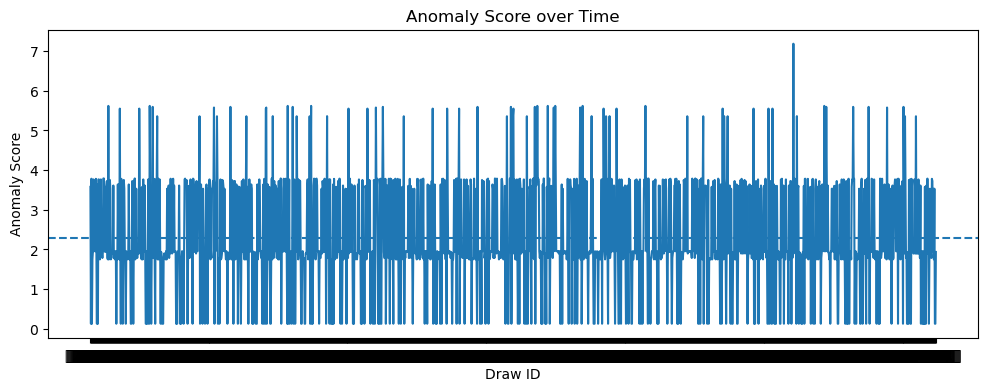

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(df["回号"], df["anomaly_score"])
plt.axhline(df["anomaly_score"].mean(), linestyle="--")
plt.title("Anomaly Score over Time")
plt.xlabel("Draw ID")
plt.ylabel("Anomaly Score")
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


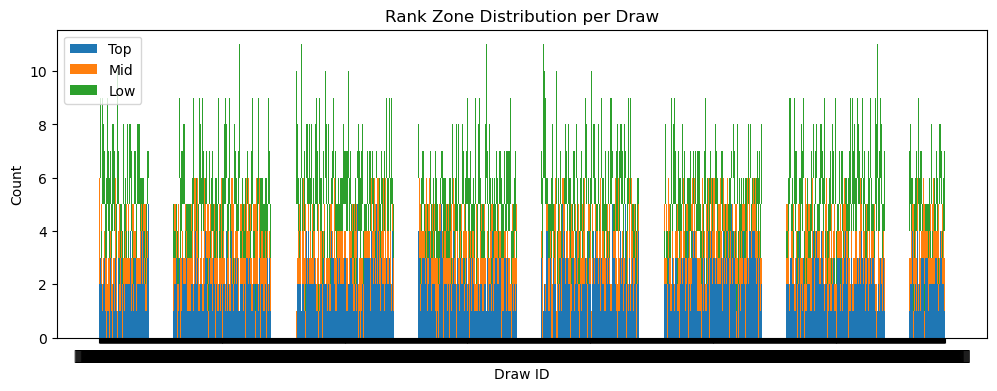

In [124]:
plt.figure(figsize=(12,4))

plt.bar(df["回号"], df["1~14_rank"], label="Top")
plt.bar(df["回号"], df["15~29_rank"],
        bottom=df["1~14_rank"], label="Mid")
plt.bar(df["回号"], df["30~43_rank"],
        bottom=df["1~14_rank"] + df["30~43_rank"], label="Low")

plt.title("Rank Zone Distribution per Draw")
plt.xlabel("Draw ID")
plt.ylabel("Count")
plt.legend()
plt.show()


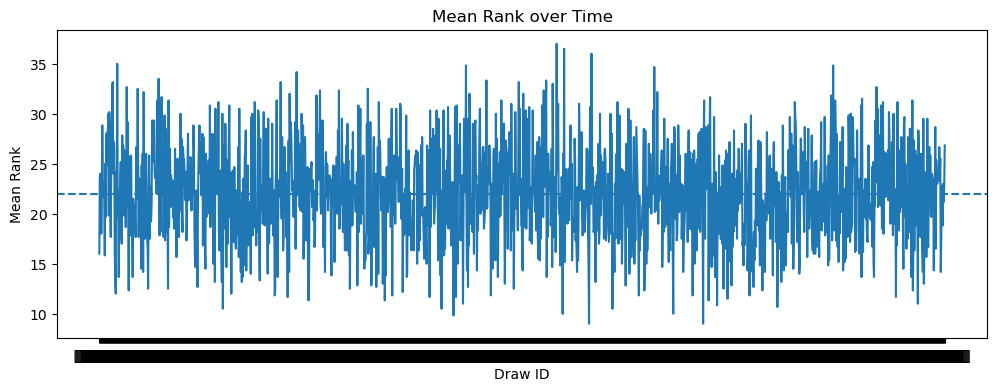

In [125]:
plt.figure(figsize=(12,4))
plt.plot(df["回号"], df["mean_rank"])
plt.axhline(df["mean_rank"].mean(), linestyle="--")
plt.title("Mean Rank over Time")
plt.xlabel("Draw ID")
plt.ylabel("Mean Rank")
plt.show()


## 自然な形ランダム生成器

In [149]:
import pandas as pd
import random
from collections import Counter

# ===== 設定 =====
WINDOW = 50
NUM_COLS = ["nm1","nm2","nm3","nm4","nm5","nm6"]

# ===== ランク帯定義 =====
def rank_zone(rank):
    if rank <= 14:
        return "top"
    elif rank <= 29:
        return "mid"
    else:
        return "low"

# ===== 自然な形ランダム生成器 =====
def generate_natural_numbers(df, structure=(2,2,2)):
    """
    structure = (top, mid, low)
    """
    df = df.sort_values("回号").reset_index(drop=True)

    if len(df) < WINDOW:
        raise ValueError("データが50回分未満です")

    past = df.iloc[-WINDOW:]

    # --- 直前50回の頻度集計 ---
    nums = []
    for _, row in past.iterrows():
        nums.extend([row[c] for c in NUM_COLS])

    freq = Counter(nums)

    # --- ランキング作成 ---
    all_nums = list(range(1, 44))
    ranking = sorted(
        all_nums,
        key=lambda x: (-freq.get(x, 0), x)
    )

    rank_map = {num: r+1 for r, num in enumerate(ranking)}

    # --- 帯ごとに分ける ---
    zones = {"top": [], "mid": [], "low": []}
    for n in all_nums:
        zones[rank_zone(rank_map[n])].append(n)

    # --- 各帯からランダム抽出 ---
    result = []
    result += random.sample(zones["top"], structure[0])
    result += random.sample(zones["mid"], structure[1])
    result += random.sample(zones["low"], structure[2])

    return sorted(result)


numbers = generate_natural_numbers(results, structure=(2,2,2))
numbers

[13, 16, 22, 24, 32, 42]

### 使わない

In [320]:
import pandas as pd

df = concat_df.copy()

# 念のため：列名が 0..6 であることを前提に処理
label_col = 0
date_col  = 1
num_cols  = [1, 2, 3, 4, 5, 6]

def to_one_row(group: pd.DataFrame) -> pd.Series:
    # 0列のラベルを文字列化（空白があっても耐える）
    labels = group[label_col].astype(str).str.strip()

    # 抽せん日（=抽選日として出力）
    date = group.loc[labels.isin(["抽せん日", "抽選日"]), date_col].iloc[0]

    # 本数字（1〜6列を結合）
    nums = group.loc[labels == "本数字", num_cols].iloc[0].astype(str).tolist()
    nums = [x for x in nums if x != "nan"]  # 念のため
    main_numbers = ",".join(nums)

    # ボーナス数字（1列目に入ってる）
    bonus = int(str(group.loc[labels == "ボーナス数字", date_col].iloc[0]).strip("()"))


    return pd.Series({"抽選日": date, "本数字": main_numbers, "ボーナス数字": bonus})

result_df = df.groupby(df.index, sort=False).apply(to_one_row).reset_index(names="回号")
result_df


,回号,抽選日,本数字,ボーナス数字
0,第2065回,2026/01/05,"6,18,21,31,37,40",3
1,第2066回,2026/01/08,"8,28,30,32,37,38",5
2,第1970回,2025/02/03,"11,26,27,31,36,37",42
3,第1971回,2025/02/06,"2,6,9,26,32,36",23
4,第1972回,2025/02/10,"3,14,27,28,32,36",12
...,...,...,...,...
92,第2034回,2025/09/15,"2,13,22,25,35,37",17
93,第2035回,2025/09/18,"5,10,12,17,21,35",9
94,第2036回,2025/09/22,"7,10,17,26,35,42",33
95,第2037回,2025/09/25,"7,12,20,23,27,29",10


In [327]:
nums_df = result_df["本数字"].str.split(",", expand=True)

# 列名 num1〜num6
nums_df.columns = [f"mn{i}" for i in range(1, nums_df.shape[1] + 1)]

# 数値化
nums_df = nums_df.astype(int)

# ===== ③ すべて結合 =====
final_df2 = pd.concat(
    [
        result_df[["回号", "抽選日", "ボーナス数字"]],
        nums_df
    ],
    axis=1
)

final_df2 = final_df2[
    ["回号", "抽選日", "mn1", "mn2", "mn3", "mn4", "mn5", "mn6", "ボーナス数字"]
]

final_df2

,回号,抽選日,mn1,mn2,mn3,mn4,mn5,mn6,ボーナス数字
0,第2065回,2026/01/05,6,18,21,31,37,40,3
1,第2066回,2026/01/08,8,28,30,32,37,38,5
2,第1970回,2025/02/03,11,26,27,31,36,37,42
3,第1971回,2025/02/06,2,6,9,26,32,36,23
4,第1972回,2025/02/10,3,14,27,28,32,36,12
...,...,...,...,...,...,...,...,...,...
92,第2034回,2025/09/15,2,13,22,25,35,37,17
93,第2035回,2025/09/18,5,10,12,17,21,35,9
94,第2036回,2025/09/22,7,10,17,26,35,42,33
95,第2037回,2025/09/25,7,12,20,23,27,29,10


In [286]:
# 抽選日を datetime に変換
final_df2["抽選日"] = pd.to_datetime(final_df2["抽選日"])

# 古い順に並び替え
final_df2 = final_df2.sort_values("抽選日", ascending=False).reset_index(drop=True)
final_df2

,回号,抽選日,mn1,mn2,mn3,mn4,mn5,mn6,ボーナス数字
0,第2066回,2026-01-08,8,28,30,32,37,38,5
1,第2065回,2026-01-05,6,18,21,31,37,40,3
2,第2064回,2025-12-29,2,7,24,37,39,41,3
3,第2063回,2025-12-25,4,28,29,30,38,42,15
4,第2062回,2025-12-22,1,9,18,24,35,42,8
...,...,...,...,...,...,...,...,...,...
92,第1974回,2025-02-17,2,6,13,21,24,30,43
93,第1973回,2025-02-13,7,10,14,27,28,32,4
94,第1972回,2025-02-10,3,14,27,28,32,36,12
95,第1971回,2025-02-06,2,6,9,26,32,36,23


In [333]:
def create_results_process(group: pd.DataFrame):
    df = results.copy()
    # 念のため：列名が 0..6 であることを前提に処理
    label_col = 0
    date_col  = 1
    num_cols  = [1, 2, 3, 4, 5, 6]

    kaigou = group.index[0]

    # 0列のラベルを文字列化
    labels = group[label_col].astype(str).str.strip()

    # 抽せん日（=抽選日として出力）
    date = group.loc[labels.isin(["抽せん日", "抽選日"]), date_col].iloc[0]

    # 本数字（1〜6列を結合）
    nums = group.loc[labels == "本数字", num_cols].iloc[0].astype(str).tolist()
    nums = [x for x in nums if x != "nan"]  # 念のため
    main_numbers = ",".join(nums)

    # ボーナス数字（1列目に入ってる）
    bonus = int(str(group.loc[labels == "ボーナス数字", date_col].iloc[0]).strip("()"))

    return pd.Series({
            "回号": kaigou,
            "抽選日": date,
            "ボーナス数字": bonus,
            "num1": nums[0],
            "num2": nums[1],
            "num3": nums[2],
            "num4": nums[3],
            "num5": nums[4],
            "num6": nums[5],
        })


In [334]:
results = create_results_process(group=pd.DataFrame)
results

TypeError: 'pandas._libs.properties.AxisProperty' object is not subscriptable

In [ ]:
# 本数字を各行に分解
    processed_df = result_df["本数字"].str.split(",", expand=True)

    # 列名 mn1〜mn6
    processed_df.columns = [f"mn{i}" for i in range(1, processed_df.shape[1] + 1)]

    # 数値化
    processed_df = processed_df.astype(int)

    # 結合
    final_df = pd.concat(
        [
            result_df[["回号", "抽選日", "ボーナス数字"]],
            processed_df
        ],
        axis=1
    )

    # 並び替え
    final_df = final_df[
        ["回号", "抽選日", "mn1", "mn2", "mn3", "mn4", "mn5", "mn6", "ボーナス数字"]
    ]

    # 抽選日を datetime に変換
    final_df["抽選日"] = pd.to_datetime(final_df["抽選日"])

    # 最新順に並び替え
    final_df = final_df.sort_values("抽選日", ascending=False).reset_index(drop=True)
    return final_df

In [356]:
import pandas as pd
import urllib.request as req
from bs4 import BeautifulSoup

url = "https://takarakuji.rakuten.co.jp/backnumber/loto6_detail/1961-1969/"
html = req.urlopen(url).read()
dfs = pd.read_html(html, encoding="utf-8")

# "抽選日"があるテーブルのみを抽出
count = 0
indexes = []
for i, df in enumerate(dfs):
    if df.astype(str).apply(lambda x: x.str.contains("抽せん日")).any().any():
        count += 1
        indexes.append(i)
target_dfs = [dfs[i] for i in indexes]
target_dfs

IndexError: list index out of range

In [102]:
processed_dfs = []

for df in target_dfs:
    df2 = df.drop(index=range(3, 9), errors="ignore")
    processed_dfs.append(df2)
processed_dfs[0]

,回号,第2065回,第2065回.1,第2065回.2,第2065回.3,第2065回.4,第2065回.5
0,抽せん日,2026/01/05,2026/01/05,2026/01/05,2026/01/05,2026/01/05,2026/01/05
1,本数字,6,18,21,31,37,40
2,ボーナス数字,(3),NaN,NaN,NaN,NaN,NaN


In [95]:
race_id = processed_dfs[0].columns[1]   # 第2065回

df2 = processed_dfs[0].copy()
df2.columns = df2.iloc[0]
df2 = df2.iloc[1:].reset_index(drop=True)
df2.index = [race_id] * len(df2)
df2


,抽せん日,2026/01/05,2026/01/05,2026/01/05,2026/01/05,2026/01/05,2026/01/05
第2065回,本数字,6,18,21,31,37,40
第2065回,ボーナス数字,(3),NaN,NaN,NaN,NaN,NaN


In [354]:
url = "https://takarakuji.rakuten.co.jp/backnumber/loto6/202601/"
html = req.urlopen(url).read()
dfs = pd.read_html(html, encoding="utf-8")
dfs[0]

,回号,第2065回,第2065回.1,第2065回.2,第2065回.3,第2065回.4,第2065回.5
0,抽せん日,2026/01/05,2026/01/05,2026/01/05,2026/01/05,2026/01/05,2026/01/05
1,本数字,6,18,21,31,37,40
2,ボーナス数字,(3),NaN,NaN,NaN,NaN,NaN
3,1等,該当なし,該当なし,該当なし,該当なし,該当なし,該当なし
4,2等,5口,5口,5口,"15,198,300円","15,198,300円","15,198,300円"
5,3等,215口,215口,215口,"381,700円","381,700円","381,700円"
6,4等,"10,741口","10,741口","10,741口","8,000円","8,000円","8,000円"
7,5等,"178,338口","178,338口","178,338口","1,000円","1,000円","1,000円"
8,キャリーオーバー,"259,218,384円","259,218,384円","259,218,384円","259,218,384円","259,218,384円","259,218,384円"
